In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr, mannwhitneyu
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, LassoCV, LogisticRegression
from sklearn.metrics import mean_squared_error, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score, train_test_split
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

#N-number seeding before answering the questions
n_number = 16154377
#Use the RNG for later for correct answers to be seeded as my solution
random.seed(n_number) #Seeds Python's random module
np.random.seed(n_number) #Seeds NumPy's random generator

#Set alpha value
alpha = 0.005

#Open the files
rmpNum = pd.read_csv('rmpCapstoneNum.csv', header=None)
rmpQual = pd.read_csv('rmpCapstoneQual.csv', header=None)

#Set the columns
rmpNum.columns = ['Average Rating', 'Average Difficulty', 'Number of Ratings', 'Received a "Pepper"?',
                  'Would Take Again Proportion', 'Number of Online Ratings', 'Male', 'Female']
rmpQual.columns = ['Major', 'University', 'US State']

#Considerations/Clean the Data/Preprocessing
#This is before answering all questions, some questions will need further cleaning/processing
#Add the Major column from rmpQual to rmpNum for the extra credit and before any filterings as the rows in both files match
rmpNum['Major'] = rmpQual['Major']

#Rearrange the columns such that Major is in first column for readability
columns_rearrange = ['Major'] + [col for col in rmpNum.columns if col != 'Major']
rmpNum = rmpNum[columns_rearrange]

#Filter the data such that the Number of Ratings is at least 8
rmpNum_filtered = rmpNum[(rmpNum['Number of Ratings'] >= 8)]

#Create a new gender column, where Male = 1 and Female = 0 is 0, Male = 0 and Female = 1 is 1, and all other combinations is 2
rmpNum_filtered['Gender'] = rmpNum_filtered.apply(
    lambda row: 0 if row['Male'] == 1 and row['Female'] == 0 else
                1 if row['Male'] == 0 and row['Female'] == 1 else
                2, axis = 1
)

p-value: 0.00013127608058250643
Male Mean Rating: 3.95, Median Rating: 4.2
Female Mean Rating: 3.88, Median Rating: 4.1
Yes, there is evidence of a pro-male gender bias in this dataset.


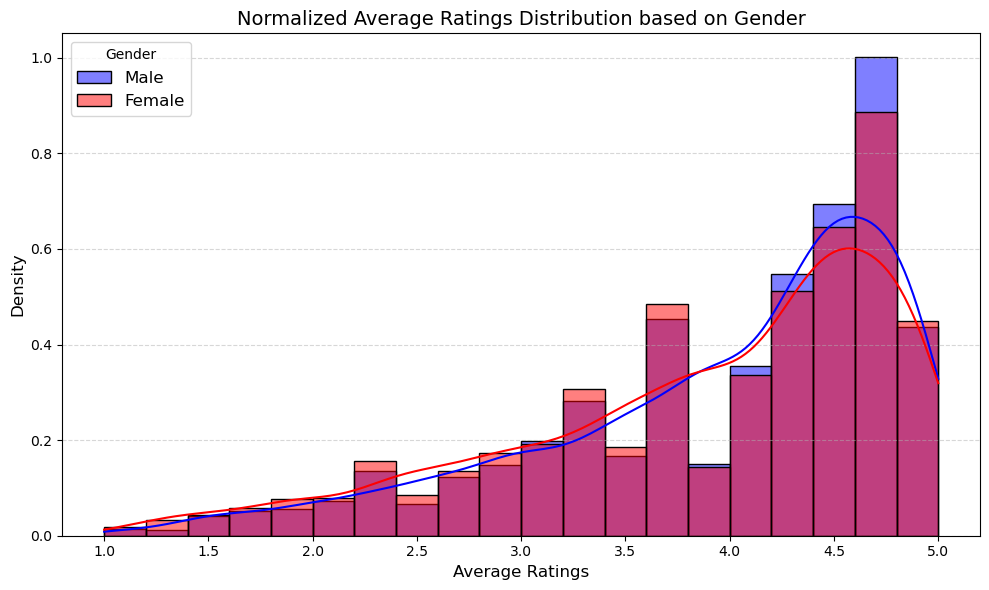

In [2]:
#%% Question 1
#Create two separate dataframes of Male (Gender = 0) and Female (Gender = 1) Average Ratings
#Data with Gender = 2 are filtered out in this case
male_avg_ratings1 = rmpNum_filtered[rmpNum_filtered['Gender'] == 0]['Average Rating']
female_avg_ratings1 = rmpNum_filtered[rmpNum_filtered['Gender'] == 1]['Average Rating']

#Perform Mann-Whitney U Test (significance test when not assuming data is normally distributed)
stats1, pval1 = mannwhitneyu(male_avg_ratings1, female_avg_ratings1)

#Find mean and median ratings to evaluate gender bias
male_mean1 = male_avg_ratings1.mean()
female_mean1 = female_avg_ratings1.mean()
male_median1 = male_avg_ratings1.median()
female_median1 = female_avg_ratings1.median()

print(f"p-value: {pval1}")
print(f"Male Mean Rating: {male_mean1:.2f}, Median Rating: {male_median1}")
print(f"Female Mean Rating: {female_mean1:.2f}, Median Rating: {female_median1}")

#Checks if p-value is less than alpha for statistical significance, then checks the gender bias
if (pval1 < alpha):
    bias = "male" if male_median1 > female_median1 else "female"
    print(f"Yes, there is evidence of a pro-{bias} gender bias in this dataset.")
else:
    print("No, there is no evidence of gender bias in this dataset.")
    
#Create a histogram to visualize the ratings
plt.figure(figsize=(10, 6))
sns.histplot(male_avg_ratings1, bins=20, alpha=0.5, color='blue', stat='density', kde=True, label='Male')
sns.histplot(female_avg_ratings1, bins=20, alpha=0.5, color='red', stat='density', kde=True, label='Female')
plt.title("Normalized Average Ratings Distribution based on Gender", fontsize=14)
plt.xlabel("Average Ratings", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend(title='Gender', fontsize=12)
plt.tight_layout()
plt.show()

                            OLS Regression Results                            
Dep. Variable:         Average Rating   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     55.36
Date:                Mon, 17 Mar 2025   Prob (F-statistic):           1.06e-13
Time:                        21:14:11   Log-Likelihood:                -18375.
No. Observations:               13995   AIC:                         3.675e+04
Df Residuals:                   13993   BIC:                         3.677e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 3.8131      0.01

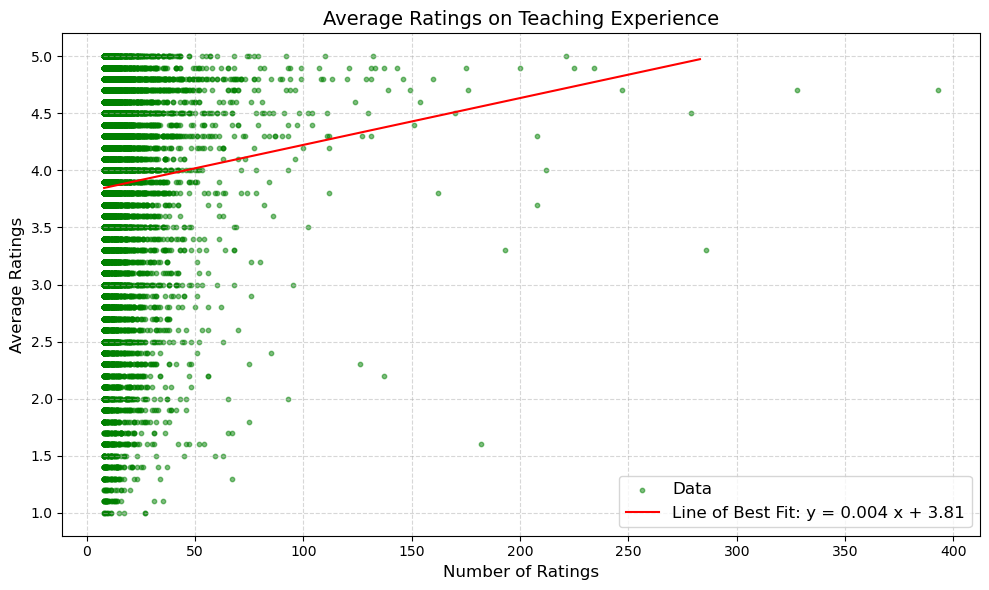

In [3]:
#%% Question 2
X2 = rmpNum_filtered[['Number of Ratings']]
y2 = rmpNum_filtered['Average Rating']

X2 = sm.add_constant(X2)

#Create an OLS model to get the p-value, r^2 and correlation coefficient (r) values
model2 = sm.OLS(y2, X2).fit()
print(model2.summary())

pval2 = model2.pvalues[1]
r_squared2 = model2.rsquared
corr_coef2 = r_squared2 ** 0.5

print(f"p-value: {pval2}")
print(f"r-squared: {r_squared2:.3f}")
print(f"Correlation Coefficient: {corr_coef2:.3f}")

#Extract slope and intercept from OLS to get the equation for the line of best fit
slope2 = model2.params['Number of Ratings']
intercept2 = model2.params['const']
X2_range = np.linspace(X2['Number of Ratings'].min(), X2['Number of Ratings'].max())
y2_predict = X2_range * slope2 + intercept2

#Filter the line of best fit to not go over 5.0
range2 = y2_predict <= 5.0
X2_range = X2_range[range2]
y2_predict = y2_predict[range2]

#Visualize the data using a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(X2['Number of Ratings'], y2, color='green', alpha=0.5, s=10, label='Data')
plt.plot(X2_range, y2_predict, color='red', label=f'Line of Best Fit: y = {slope2:.3f} x + {intercept2:.2f}')
plt.title("Average Ratings on Teaching Experience", fontsize=14)
plt.xlabel("Number of Ratings", fontsize=12)
plt.ylabel("Average Ratings", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

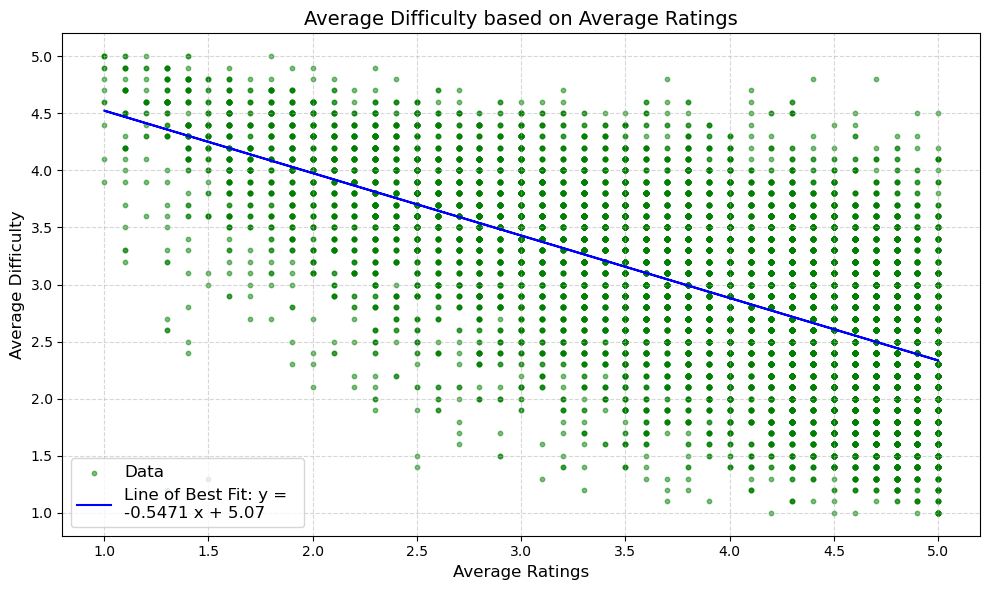

Spearman's Correlation Coefficient: -0.623
Spearman's r-squared: 0.388
Spearman's p-value: 0.0
Pearson's Correlation Coefficient: -0.639
Pearson's r-squared: 0.409
Pearson's p-value: 0.0


In [4]:
#%% Question 3
avg_rating3 = rmpNum_filtered['Average Rating']
avg_difficulty3 = rmpNum_filtered['Average Difficulty']

#Find Regression Line for plot; perform linear fit first, then create the function
coef3 = np.polyfit(avg_rating3, avg_difficulty3, 1)
poly3 = np.poly1d(coef3)

#Create scatter plot and plot the points along with the Line of Best Fit
#Data visualization is critical in identifying relationships
plt.figure(figsize=(10, 6))
plt.scatter(avg_rating3, avg_difficulty3, color='green', alpha=0.5, s=10, label='Data')
plt.plot(avg_rating3, poly3(avg_rating3), color='blue', label=f'Line of Best Fit: y = {poly3}')
plt.title("Average Difficulty based on Average Ratings", fontsize=14)
plt.xlabel("Average Ratings", fontsize=12)
plt.ylabel("Average Difficulty", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

#Calculate Spearman's Correlation Coefficient and p-value (not assuming linear relationship)
spearman_corr3, spearman_p3 = spearmanr(avg_rating3, avg_difficulty3)
spearman_r_squared3 = spearman_corr3 ** 2

#Bonus: Calculate the Pearson's Correlation Coefficient
pearson_corr3, pearson_p3 = pearsonr(avg_rating3, avg_difficulty3)
pearson_r_squared3 = pearson_corr3 ** 2

print(f"Spearman's Correlation Coefficient: {spearman_corr3:.3f}")
print(f"Spearman's r-squared: {spearman_r_squared3:.3f}")
print(f"Spearman's p-value: {spearman_p3}")
print(f"Pearson's Correlation Coefficient: {pearson_corr3:.3f}")
print(f"Pearson's r-squared: {pearson_r_squared3:.3f}")
print(f"Pearson's p-value: {pearson_p3}")

p-value: 0.0020367185640738777
More Online Mean Rating: 3.69, Median Rating: 4.0
Less Online Mean Rating: 3.88, Median Rating: 4.1


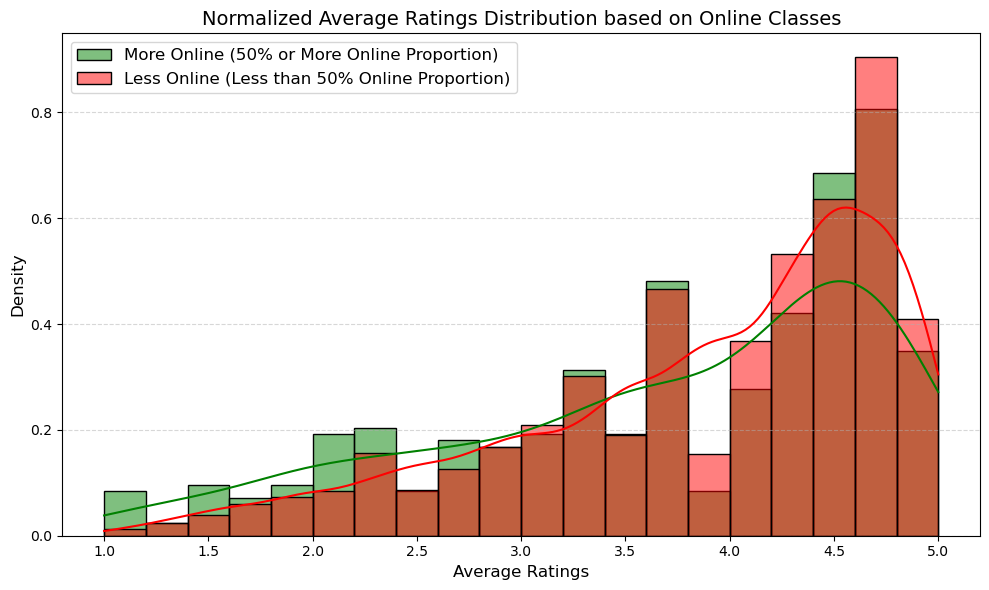

In [5]:
#%% Question 4
#We will consider more online classes as professors with 50% or higher online proportion
#and less online classes as those with less than 50% online proportion
#Extract all the necessary columns
rmpNum_filtered4 = rmpNum_filtered[['Average Rating', 'Number of Ratings', 'Number of Online Ratings']]

#Calculate the percentage of Online Ratings to Total Number of Ratings and store the values in a new column
rmpNum_filtered4['Online Proportion'] = rmpNum_filtered['Number of Online Ratings']/rmpNum_filtered['Number of Ratings']

#Get the Average Rating for both cases
more_online_ratings4 = rmpNum_filtered4[rmpNum_filtered4['Online Proportion'] >= 0.5]['Average Rating']
less_online_ratings4 = rmpNum_filtered4[rmpNum_filtered4['Online Proportion'] < 0.5]['Average Rating']

#Find the mean and median average ratings in both dataframes
more_online_ratings_mean4 = more_online_ratings4.mean()
less_online_ratings_mean4 = less_online_ratings4.mean()
more_online_ratings_median4 = more_online_ratings4.median()
less_online_ratings_median4 = less_online_ratings4.median()

#Perform Mann-Whitney U Test (significance test when not assuming data is normally distributed and that data is independent)
stats4, pval4 = mannwhitneyu(more_online_ratings4, less_online_ratings4)

print(f"p-value: {pval4}")
print(f"More Online Mean Rating: {more_online_ratings_mean4:.2f}, Median Rating: {more_online_ratings_median4}")
print(f"Less Online Mean Rating: {less_online_ratings_mean4:.2f}, Median Rating: {less_online_ratings_median4}")

#Create a histogram to visualize the ratings
plt.figure(figsize=(10, 6))
sns.histplot(more_online_ratings4, bins=20, alpha=0.5, color='green', stat='density', kde=True,
             label='More Online (50% or More Online Proportion)')
sns.histplot(less_online_ratings4, bins=20, alpha=0.5, color='red', stat='density', kde=True,
             label='Less Online (Less than 50% Online Proportion)')
plt.title("Normalized Average Ratings Distribution based on Online Classes", fontsize=14)
plt.xlabel("Average Ratings", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

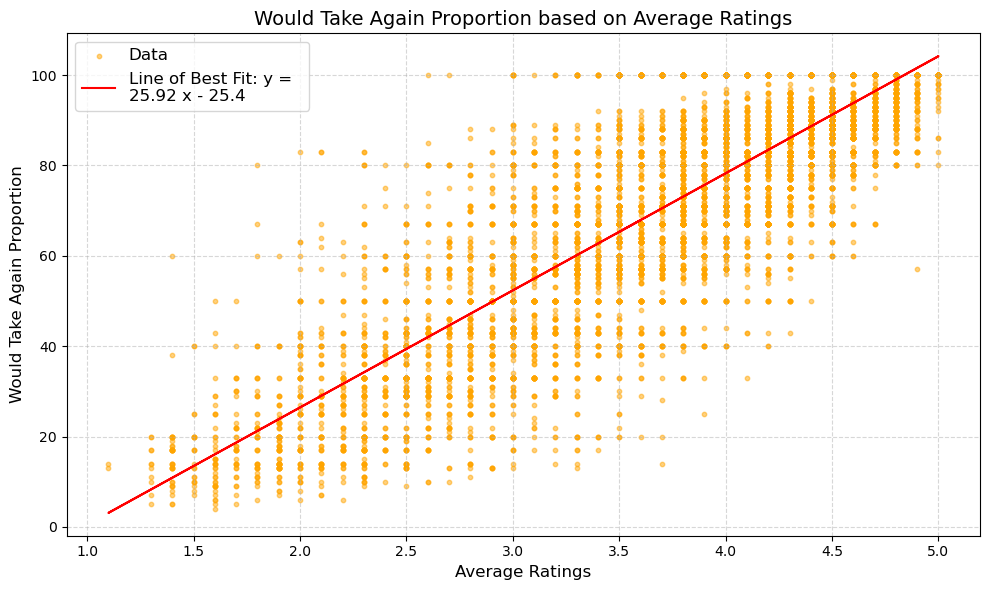

Spearman's Correlation Coefficient: 0.843
Spearman's r-squared: 0.711
Spearman's p-value: 0.0
Pearson's Correlation Coefficient: 0.876
Pearson's r-squared: 0.767
Pearson's p-value: 0.0


In [6]:
#%% Question 5
#Get the Average Rating and Would Take Again columns into a dataframe first and drop NaNs as there are rows where Would Take Again are NaNs
rmpNum_filtered5 = rmpNum_filtered[['Average Rating', 'Would Take Again Proportion']].dropna()
avg_rating5 = rmpNum_filtered5['Average Rating']
would_take_again5 = rmpNum_filtered5['Would Take Again Proportion']

#Find Regression Line for plot; perform linear fit first, then create the function
coef5 = np.polyfit(avg_rating5, would_take_again5, 1)
poly5 = np.poly1d(coef5)

#Create scatter plot and plot the points along with the Line of Best Fit
plt.figure(figsize=(10, 6))
plt.scatter(avg_rating5, would_take_again5, color='orange', alpha=0.5, s=10, label='Data')
plt.plot(avg_rating5, poly5(avg_rating5), color='red', label=f'Line of Best Fit: y = {poly5}')
plt.title("Would Take Again Proportion based on Average Ratings", fontsize=14)
plt.xlabel("Average Ratings", fontsize=12)
plt.ylabel("Would Take Again Proportion", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

#Calculate Spearman's Correlation Coefficient and p-value (not assuming linear relationship)
spearman_corr5, spearman_p5 = spearmanr(avg_rating5, would_take_again5)
spearman_r_squared5 = spearman_corr5 ** 2

#Bonus: Calculate the Pearson's Correlation Coefficient
pearson_corr5, pearson_p5 = pearsonr(avg_rating5, would_take_again5)
pearson_r_squared5 = pearson_corr5 ** 2

print(f"Spearman's Correlation Coefficient: {spearman_corr5:.3f}")
print(f"Spearman's r-squared: {spearman_r_squared5:.3f}")
print(f"Spearman's p-value: {spearman_p5}")
print(f"Pearson's Correlation Coefficient: {pearson_corr5:.3f}")
print(f"Pearson's r-squared: {pearson_r_squared5:.3f}")
print(f"Pearson's p-value: {pearson_p5}")

p-value: 0.0
Hot Professors Mean Rating: 4.36, Median Rating: 4.5
Not Hot Professors Mean Rating: 3.46, Median Rating: 3.6


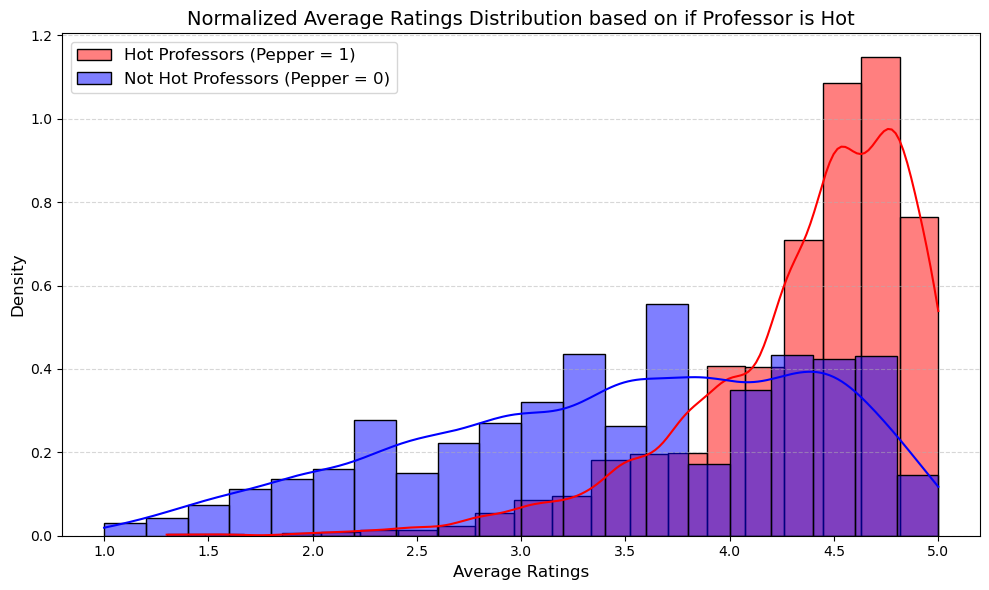

In [7]:
#%% Question 6
#Separate the average ratings of professors deemed "hot" (Pepper=1) and not (Pepper=0) into separate sub-dataframes
hot_professors_ratings6 = rmpNum_filtered[rmpNum_filtered['Received a "Pepper"?'] == 1]['Average Rating']
not_hot_professors_ratings6 = rmpNum_filtered[rmpNum_filtered['Received a "Pepper"?'] == 0]['Average Rating']

#Find the mean and median average ratings in both dataframes
hot_professors_ratings_mean6 = hot_professors_ratings6.mean()
not_hot_professors_ratings_mean6 = not_hot_professors_ratings6.mean()
hot_professors_ratings_median6 = hot_professors_ratings6.median()
not_hot_professors_ratings_median6 = not_hot_professors_ratings6.median()

#Perform Mann-Whitney U Test (significance test when not assuming data is normally distributed)
stats6, pval6 = mannwhitneyu(hot_professors_ratings6, not_hot_professors_ratings6)

print(f"p-value: {pval6}")
print(f"Hot Professors Mean Rating: {hot_professors_ratings_mean6:.2f}, Median Rating: {hot_professors_ratings_median6}")
print(f"Not Hot Professors Mean Rating: {not_hot_professors_ratings_mean6:.2f}, Median Rating: {not_hot_professors_ratings_median6}")

#Create a histogram to visualize the ratings
plt.figure(figsize=(10, 6))
sns.histplot(hot_professors_ratings6, bins=20, alpha=0.5, color='red', stat='density', kde=True, label='Hot Professors (Pepper = 1)')
sns.histplot(not_hot_professors_ratings6, bins=20, alpha=0.5, color='blue', stat='density', kde=True,
             label='Not Hot Professors (Pepper = 0)')
plt.title("Normalized Average Ratings Distribution based on if Professor is Hot", fontsize=14)
plt.xlabel("Average Ratings", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

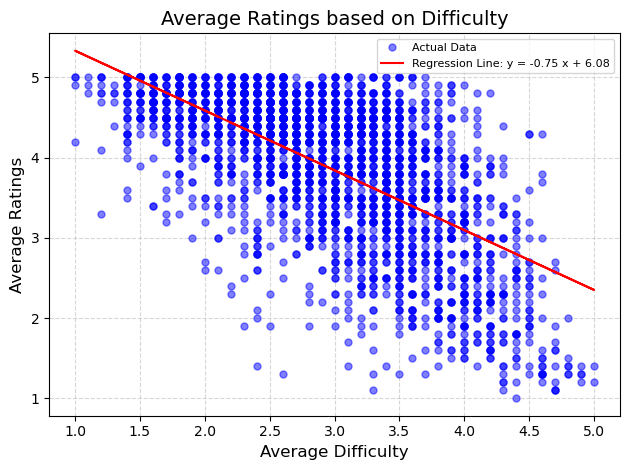

Cross-Validation Mean r-squared: 0.411
Cross-Validation Mean RMSE: 0.689
Test r-squared: 0.399
Test RMSE: 0.708


In [8]:
#%% Question 7
#Average Difficulty is independent variable and Average Rating is dependent variable (also what we are predicting)
X7 = rmpNum_filtered[['Average Difficulty']]
y7 = rmpNum_filtered['Average Rating']

#Run an 80/20 train-test split, using my N-number as random state for result uniqueness
X7_train, X7_test, y7_train, y7_test = train_test_split(X7, y7, test_size=0.2, random_state=n_number)

#Train a Linear Regression model on training data as there is only one column in independent variable
model7 = LinearRegression()

#But first, do a 5-fold cross-validation for r^2 and RMSE
cv7 = cross_val_score(model7, X7_train, y7_train, cv=5, scoring='r2')
cv7_mean = np.mean(cv7)
cv7_rmse = -(cross_val_score(model7, X7_train, y7_train, cv=5, scoring='neg_root_mean_squared_error'))
cv7_rmse_mean = np.mean(cv7_rmse)

#Fit the model
model7.fit(X7_train, y7_train)

#Make predictions from test data
predictions7 = model7.predict(X7_test)

#Get the slope and intercept from the model
slope7 = model7.coef_[0]
intercept7 = model7.intercept_

#Create a scatter plot between the Actual Test Ratings and Prediction Ratings of the regression for a visualization
plt.figure(figure=(10, 6))
plt.plot(X7_test, y7_test, 'o', color='blue', alpha=0.5, markersize=5, label='Actual Data')
plt.plot(X7_test, predictions7, '-', color='red', markersize=5, label=f'Regression Line: y = {slope7:.2f} x + {intercept7:.2f}')
plt.title('Average Ratings based on Difficulty', fontsize=14)
plt.xlabel('Average Difficulty', fontsize=12)
plt.ylabel('Average Ratings', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=8)
plt.tight_layout()
plt.show()

#Use score to find r^2, then find RMSE by calculating the mean residual and square rooting it
r_squared7 = model7.score(X7_test, y7_test)
rmse7 = np.sqrt(mean_squared_error(y7_test, predictions7))

print(f"Cross-Validation Mean r-squared: {cv7_mean:.3f}")
print(f"Cross-Validation Mean RMSE: {cv7_rmse_mean:.3f}")
print(f"Test r-squared: {r_squared7:.3f}")
print(f"Test RMSE: {rmse7:.3f}")

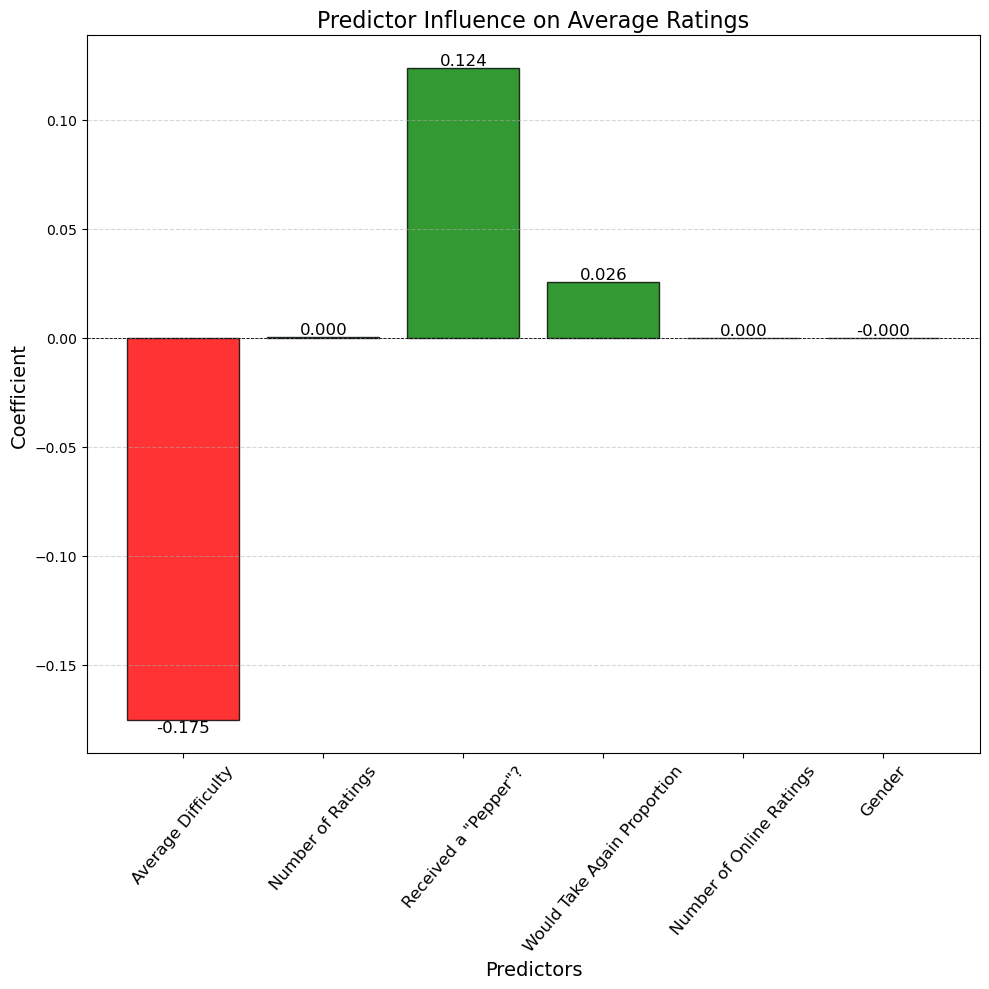

Cross-Validation Mean r-squared: 0.805
Cross-Validation Mean RMSE: 0.367
Test r-squared: 0.797
Test RMSE: 0.381


In [9]:
#%% Question 8
#This time we are looking at Average Rating through all other columns as independent variables
#But first, get all necessary columns into a dataframe first and drop NaNs as there are rows where Would Take Again are NaNs
rmpNum_filtered8 = rmpNum_filtered[['Average Rating', 'Average Difficulty', 'Number of Ratings', 'Received a "Pepper"?',
                                    'Would Take Again Proportion', 'Number of Online Ratings', 'Gender']].dropna()
X8 = rmpNum_filtered8[['Average Difficulty', 'Number of Ratings', 'Received a "Pepper"?', 'Would Take Again Proportion',
                       'Number of Online Ratings', 'Gender']]
y8 = rmpNum_filtered8['Average Rating']

#Run an 80/20 train-test split, using my N-number as random state for result uniqueness
X8_train, X8_test, y8_train, y8_test = train_test_split(X8, y8, test_size=0.2, random_state=n_number)

#Train Lasso Regression model on training data for multiple predictor as X has multiple columns
#Use LassoCV for a 5-fold cross-validation
model8 = LassoCV(cv=5, random_state=n_number)

#But first, do a 5-fold cross-validation for r^2 and RMSE
cv8 = cross_val_score(model8, X8_train, y8_train, cv=5, scoring='r2')
cv8_mean = np.mean(cv8)
cv8_rmse = -(cross_val_score(model8, X8_train, y8_train, cv=5, scoring='neg_root_mean_squared_error'))
cv8_rmse_mean = np.mean(cv8_rmse)

#Fit the model
model8.fit(X8_train, y8_train)

#Make predictions from test data
predictions8 = model8.predict(X8_test)

#Get the column names and coefficients
coefficients8 = model8.coef_
predictors8 = X8.columns

#Create a Lasso table to represent each independent variable's coefficient
lasso_table8 = pd.DataFrame({'Predictor': predictors8, 'Coefficient': np.round(coefficients8, 3)})

#Add an interpretation column to represent each coefficient
lasso_table8['Interpretation'] = [
    'Positive Influence' if coef > 0 else
    'Negative Influence' if coef < 0 else
    'No Influence'
    for coef in lasso_table8['Coefficient']
]

#Create a bar graph to visualize the data
plt.figure(figsize=(10, 10))
bar8 = plt.bar(predictors8, coefficients8, color=['green' if coef8 > 0 else 'red' for coef8 in coefficients8], edgecolor='black', alpha=0.8)
plt.title('Predictor Influence on Average Ratings', fontsize=16)
plt.xlabel('Predictors', fontsize=14)
plt.ylabel('Coefficient', fontsize=14)
plt.xticks(rotation=50, ha='center', fontsize=12) #Rotate the predictor labels to avoid overlapping 
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.axhline(0, color='black', linewidth=0.6, linestyle='--')

#Add coefficient labels to each bar
for bar, coef in zip(bar8, coefficients8):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{coef:.3f}', ha='center',
             va='bottom' if coef >= 0 else 'top', fontsize=12, color='black')

plt.tight_layout()
plt.show()

#Get lambda from model, use score to find r^2, then find RMSE by calculating the mean-squared error and square rooting it
r_squared8 = model8.score(X8_test, y8_test)
rmse8 = np.sqrt(mean_squared_error(y8_test, predictions8))

print(f"Cross-Validation Mean r-squared: {cv8_mean:.3f}")
print(f"Cross-Validation Mean RMSE: {cv8_rmse_mean:.3f}")
print(f"Test r-squared: {r_squared8:.3f}")
print(f"Test RMSE: {rmse8:.3f}")

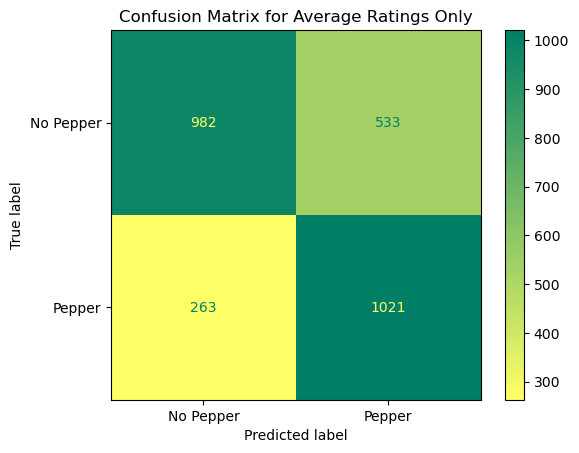

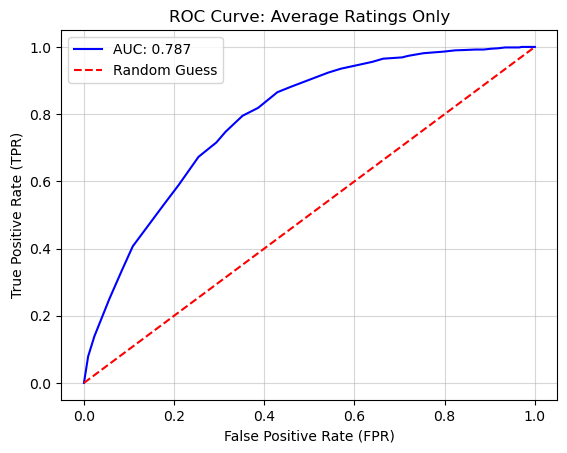

In [10]:
#%% Question 9
#Average Rating is independent variable and Received a "Pepper"? is dependent variable
X9 = rmpNum_filtered[['Average Rating']]
y9 = rmpNum_filtered['Received a "Pepper"?']

#Run an 80/20 train-test split, using my N-number as random state for result uniqueness
X9_train, X9_test, y9_train, y9_test = train_test_split(X9, y9, test_size=0.2, random_state=n_number)

#Run the Logistic Regression model on training data and set class weight to balanced to balance the weights in both variables
model9 = LogisticRegression(random_state=n_number, class_weight='balanced').fit(X9_train, y9_train)

#Make predictions for probability of hot professor (Pepper = 1) for the test data
predict_prob9 = model9.predict_proba(X9_test)[:, 1]
predictions9 = model9.predict(X9_test)

#Generate the Confusion Matrix to address class imbalances
cm9 = confusion_matrix(y9_test, predictions9)
cm9_display = ConfusionMatrixDisplay(confusion_matrix=cm9, display_labels=['No Pepper', 'Pepper'])

#Display the Matrix
cm9_display.plot(cmap='summer_r')
plt.title("Confusion Matrix for Average Ratings Only")
plt.show()

#Find AUC-ROC and Plot the Curve
auc9 = roc_auc_score(y9_test, predict_prob9)
fpr9, tpr9, thresholds9 = roc_curve(y9_test, predict_prob9)
plt.figure()
plt.plot(fpr9, tpr9, label=f'AUC: {auc9:.3f}', color='blue')
plt.plot([0,1], [0,1], linestyle='--', color='red', label='Random Guess')
plt.title('ROC Curve: Average Ratings Only')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend()
plt.grid(alpha=0.5)
plt.show()

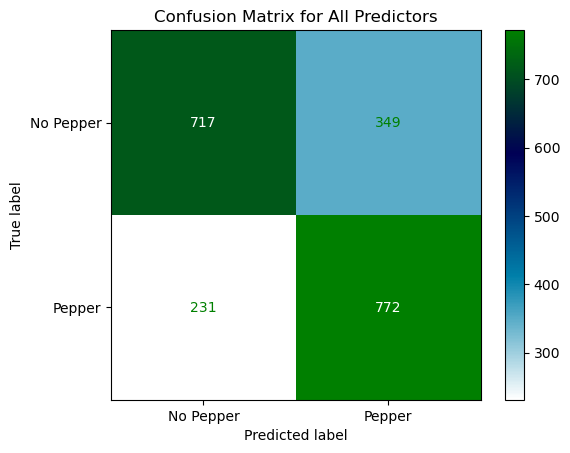

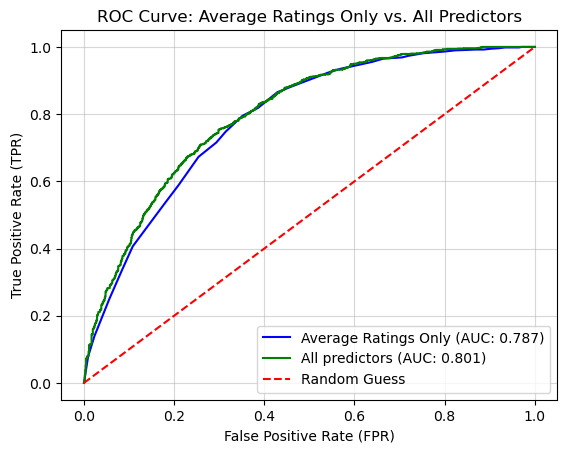

In [11]:
#%% Question 10
#This time we are looking at Received a "Pepper" through all other columns as independent variables
#We can use the filtered data from Question 8 to proceed
X10 = rmpNum_filtered8[['Average Rating', 'Average Difficulty', 'Number of Ratings',
                        'Would Take Again Proportion', 'Number of Online Ratings', 'Gender']]
y10 = rmpNum_filtered8['Received a "Pepper"?']

#Run an 80/20 train-test split, using my N-number as random state for result uniqueness
X10_train, X10_test, y10_train, y10_test = train_test_split(X10, y10, test_size=0.2, random_state=n_number)

#Run the Logistic Regression model on training data and set class weight to balanced to address potential imbalances
model10 = LogisticRegression(random_state=n_number, class_weight='balanced').fit(X10_train, y10_train)

#Make predictions for probability of hot professor (Pepper = 1) for the test data
predict_prob10 = model10.predict_proba(X10_test)[:, 1]
predictions10 = model10.predict(X10_test)

#Generate the Confusion Matrix to address class imbalances
cm10 = confusion_matrix(y10_test, predictions10)
cm10_display = ConfusionMatrixDisplay(confusion_matrix=cm10, display_labels=['No Pepper', 'Pepper'])

#Display the Matrix
cm10_display.plot(cmap='ocean_r')
plt.title("Confusion Matrix for All Predictors")
plt.show()

#Find AUC-ROC and Plot the Curve
auc10 = roc_auc_score(y10_test, predict_prob10)
fpr10, tpr10, thresholds10 = roc_curve(y10_test, predict_prob10)
plt.figure()
plt.plot(fpr9, tpr9, label=f'Average Ratings Only (AUC: {auc9:.3f})', color='blue') #To visually compare the two curves
plt.plot(fpr10, tpr10, label=f'All predictors (AUC: {auc10:.3f})', color='green')
plt.plot([0,1], [0,1], linestyle='--', color='red', label='Random Guess')
plt.title('ROC Curve: Average Ratings Only vs. All Predictors')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend()
plt.grid(alpha=0.5)
plt.show()

Ratings p-value: 1.488042240989254e-84
STEM Mean Rating: 3.72, Median Rating: 3.9, 95% Confidence Interval: 1.6 to 5.0
Non-STEM Mean Rating: 4.01, Median Rating: 4.3, 95% Confidence Interval: 1.9 to 5.0


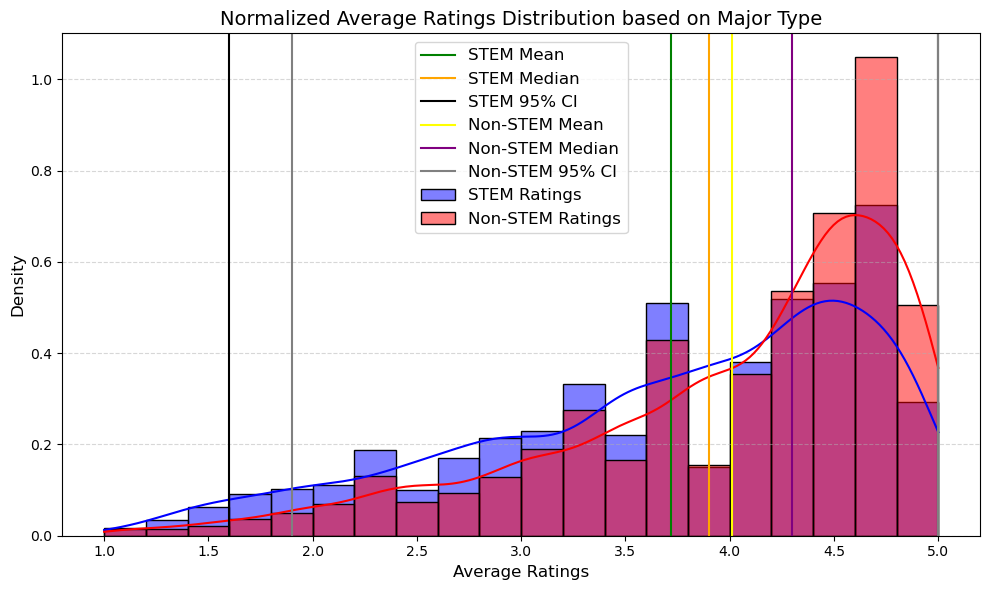

Difficulty p-value: 5.2332521885954274e-133
STEM Mean Difficulty: 3.13, Median Difficulty: 3.1, 95% Confidence Interval: 1.6 to 4.5
Non-STEM Mean Difficulty: 2.80, Median Difficulty: 2.8, 95% Confidence Interval: 1.4 to 4.3


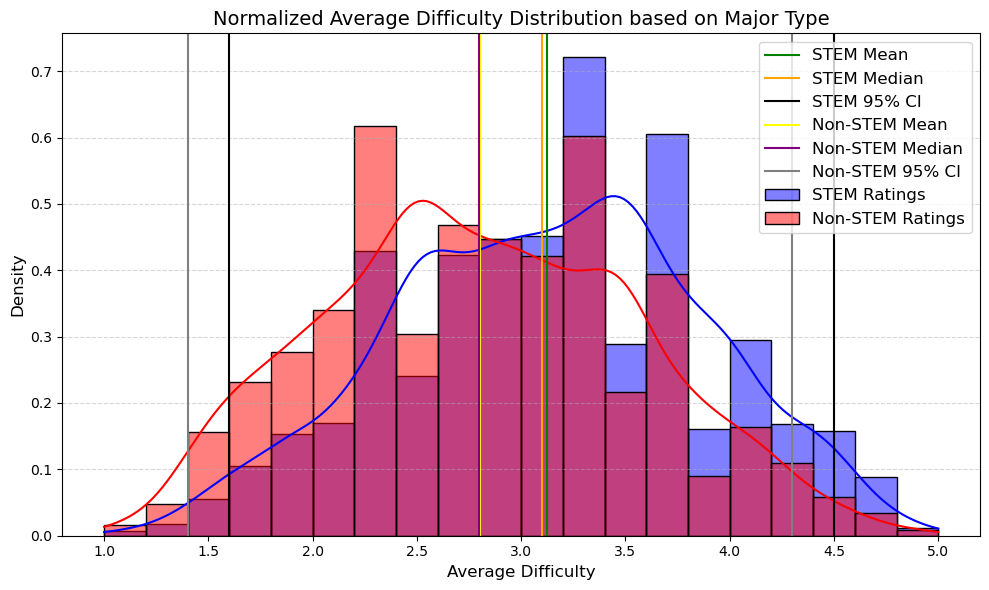

Ratings Cohen's d: 8.64, 95% Confidence Interval: 8.52 to 8.77
Difficulty Cohen's d: 7.87, 95% Confidence Interval: 7.78 to 7.95


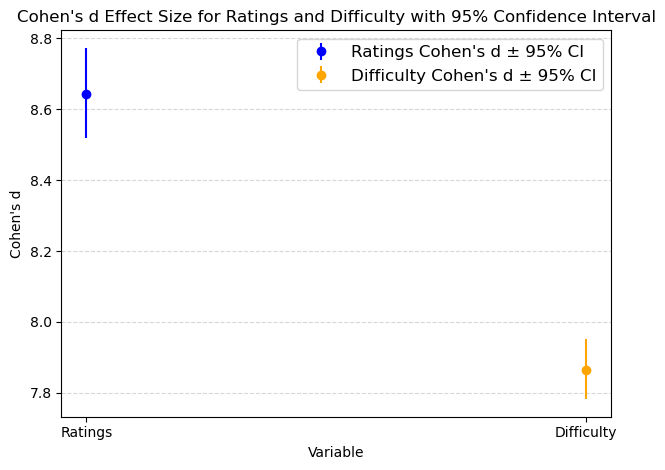

In [12]:
#%% Extra Credit

#Do professors in STEM fields receive higher or lower ratings than professors not in STEM fields? What about difficulty level?

#Get the necessary columns from the original filtered dataframe for this part
rmp_filteredEC = rmpNum_filtered[['Major', 'Average Rating', 'Average Difficulty']]

#Set keywords to classify between STEM and non-STEM majors. I did this to the best of my ability.
stem_keywords = ['Math', 'Physics', 'Chemistry', 'Bio', 'Engineering', 'Statistics', 'Computer', 'Technology', 'Data', 'Information',
                 'Economics', 'Psychology', 'Marketing', 'Astronomy', 'Aeronautics', 'Cognitive', 'Anatomy', 'Geo', 'Env', 'Science']
exclude_keywords = ['Political', 'Exercise', 'Social', 'Liberal', 'Sports', 'Family', 'Disorders']

#Function to classify major
def classify_major(major):
    if any(exclude.lower() in str(major).lower() for exclude in exclude_keywords):
        return 'Non-STEM'
    elif any(keyword.lower() in str(major).lower() for keyword in stem_keywords):
        return 'STEM'
    else:
        return 'Non-STEM'

#Add a column for classification and classify each major based on keywords
rmp_filteredEC['Classify'] = rmp_filteredEC['Major'].apply(classify_major)

#Separate the STEM and non-STEM data by classification
stem_data = rmp_filteredEC[rmp_filteredEC['Classify'] == 'STEM']
nonstem_data = rmp_filteredEC[rmp_filteredEC['Classify'] == 'Non-STEM']

#Bootstrap Function
def bootstrap(data):
    n_resamples = 10000 #For more accuracy and efficiency
    ci = 95 #95% Confidence Interval
    random_state = n_number
    
    if random_state is not None:
        np.random.seed(random_state) #Seed NumPy's random module for uniqueness
    
    #List to keep all bootstrap values
    bootstrap = []
    for j in range(n_resamples):
        sample = np.random.choice(data, size=len(data), replace=True)
        bootstrap.append(sample)
        
    lower_ci = np.percentile(bootstrap, (100 - ci) / 2)
    upper_ci = np.percentile(bootstrap, 100 - (100 - ci) / 2)
    return np.mean(bootstrap), lower_ci, upper_ci

#Part 1: Evaluate Ratings
stem_ratings = stem_data['Average Rating']
nonstem_ratings = nonstem_data['Average Rating']

#Run Mann-Whitney U Test to find p-value for statistical significance
stats_ratings, pval_ratings = mannwhitneyu(stem_ratings, nonstem_ratings)

#Find Mean, Lower and Upper Confidence Intervals by bootstrapping, and Median of both datasets
stem_ratings_mean, stem_ratings_lower_ci, stem_ratings_upper_ci = bootstrap(stem_ratings)
nonstem_ratings_mean, nonstem_ratings_lower_ci, nonstem_ratings_upper_ci = bootstrap(nonstem_ratings)
stem_ratings_median = stem_ratings.median()
nonstem_ratings_median = nonstem_ratings.median()

print(f"Ratings p-value: {pval_ratings}")
print(f"STEM Mean Rating: {stem_ratings_mean:.2f}, Median Rating: {stem_ratings_median}, 95% Confidence Interval: {stem_ratings_lower_ci} to {stem_ratings_upper_ci}")
print(f"Non-STEM Mean Rating: {nonstem_ratings_mean:.2f}, Median Rating: {nonstem_ratings_median}, 95% Confidence Interval: {nonstem_ratings_lower_ci} to {nonstem_ratings_upper_ci}")

#Create a Histogram with 95% Confidence Interval to visualize the rating distribution
plt.figure(figsize=(10, 6))
sns.histplot(stem_ratings, bins=20, alpha=0.5, color='blue', edgecolor='black', stat='density', kde=True, label='STEM Ratings')
sns.histplot(nonstem_ratings, bins=20, alpha=0.5, color='red', edgecolor='black', stat='density', kde=True, label='Non-STEM Ratings')

#Add Mean, Median, and 95% Confidence Intervals as vertical lines, color coding them
plt.axvline(stem_ratings_mean, color='green', label='STEM Mean')
plt.axvline(stem_ratings_median, color='orange', label='STEM Median')
plt.axvline(stem_ratings_lower_ci, color='black', label='STEM 95% CI')
plt.axvline(stem_ratings_upper_ci, color='black')
plt.axvline(nonstem_ratings_mean, color='yellow', label='Non-STEM Mean')
plt.axvline(nonstem_ratings_median, color='purple', label='Non-STEM Median')
plt.axvline(nonstem_ratings_lower_ci, color='gray', label='Non-STEM 95% CI')
plt.axvline(nonstem_ratings_upper_ci, color='gray')

#Add title, labels, and grids
plt.title("Normalized Average Ratings Distribution based on Major Type", fontsize=14)
plt.xlabel("Average Ratings", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

#Part 2: Evaluate Difficulty Level
stem_difficulty = stem_data['Average Difficulty']
nonstem_difficulty = nonstem_data['Average Difficulty']

#Run Mann-Whitney U Test to find p-value for statistical significance
stats_difficulty, pval_difficulty = mannwhitneyu(stem_difficulty, nonstem_difficulty)

#Find Mean, Lower and Upper Confidence Intervals by bootstrapping, and Median of both datasets
stem_difficulty_mean, stem_difficulty_lower_ci, stem_difficulty_upper_ci = bootstrap(stem_difficulty)
nonstem_difficulty_mean, nonstem_difficulty_lower_ci, nonstem_difficulty_upper_ci = bootstrap(nonstem_difficulty)
stem_difficulty_median = stem_difficulty.median()
nonstem_difficulty_median = nonstem_difficulty.median()

print(f"Difficulty p-value: {pval_difficulty}")
print(f"STEM Mean Difficulty: {stem_difficulty_mean:.2f}, Median Difficulty: {stem_difficulty_median}, 95% Confidence Interval: {stem_difficulty_lower_ci} to {stem_difficulty_upper_ci}")
print(f"Non-STEM Mean Difficulty: {nonstem_difficulty_mean:.2f}, Median Difficulty: {nonstem_difficulty_median}, 95% Confidence Interval: {nonstem_difficulty_lower_ci} to {nonstem_difficulty_upper_ci}")

#Create a Histogram with 95% Confidence Interval to visualize the difficulty distribution
plt.figure(figsize=(10, 6))
sns.histplot(stem_difficulty, bins=20, alpha=0.5, color='blue', edgecolor='black', stat='density', kde=True, label='STEM Ratings')
sns.histplot(nonstem_difficulty, bins=20, alpha=0.5, color='red', edgecolor='black', stat='density', kde=True, label='Non-STEM Ratings')

#Add Mean, Median, and 95% Confidence Intervals as vertical lines, color coding them
plt.axvline(stem_difficulty_mean, color='green', label='STEM Mean')
plt.axvline(stem_difficulty_median, color='orange', label='STEM Median')
plt.axvline(stem_difficulty_lower_ci, color='black', label='STEM 95% CI')
plt.axvline(stem_difficulty_upper_ci, color='black')
plt.axvline(nonstem_difficulty_mean, color='yellow', label='Non-STEM Mean')
plt.axvline(nonstem_difficulty_median, color='purple', label='Non-STEM Median')
plt.axvline(nonstem_difficulty_lower_ci, color='gray', label='Non-STEM 95% CI')
plt.axvline(nonstem_difficulty_upper_ci, color='gray')

#Add title, labels, and grids
plt.title("Normalized Average Difficulty Distribution based on Major Type", fontsize=14)
plt.xlabel("Average Difficulty", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

#For further analysis, find Cohen's d for effect size and bootstrap each outcome and compare them visually (Treatment vs. Control)

#Cohen's d Function for Effect Size
def cohens_d(data1, data2):
    mean1 = np.mean(data1) #Treatment group
    mean2 = np.mean(data2) #Control Group
    std1 = np.std(data1)
    std2 = np.std(data2)
    
    #Find pooled standard deviation
    pooled_sd = np.sqrt(((std1 ** 2) + (std2 ** 2))/2)
    
    #Solve for d and return value
    d = (mean1 + mean2) / pooled_sd
    return d
    
#Bootstrap Cohen's d
def bootstrap_cohens_d(data1, data2):
    n_resamples = 10000 #For more accuracy and efficiency
    ci = 95 #95% Confidence Interval
    random_state = n_number
    
    if random_state is not None:
        np.random.seed(random_state) #Seed NumPy's random module for uniqueness
    
    bootstrap_cohens_d = []
    for k in range(n_resamples):
        sample1 = np.random.choice(data1, size=len(data1), replace=True)
        sample2 = np.random.choice(data2, size=len(data2), replace=True)
        bootstrap_cohens_d.append(cohens_d(sample1, sample2))
    
    lower_ci = np.percentile(bootstrap_cohens_d, (100 - ci) / 2)
    upper_ci = np.percentile(bootstrap_cohens_d, 100 - (100 - ci) / 2)
    return lower_ci, upper_ci

#Find Cohen's d for effect size and bootstrap each outcome and compare them visually (Treatment vs. Control)
ratings_cohens_d = cohens_d(stem_ratings, nonstem_ratings)
ratings_lower_ci, ratings_upper_ci = bootstrap_cohens_d(stem_ratings, nonstem_ratings)
difficulty_cohens_d = cohens_d(stem_difficulty, nonstem_difficulty)
difficulty_lower_ci, difficulty_upper_ci = bootstrap_cohens_d(stem_difficulty, nonstem_difficulty)

print(f"Ratings Cohen's d: {ratings_cohens_d:.2f}, 95% Confidence Interval: {ratings_lower_ci:.2f} to {ratings_upper_ci:.2f}")
print(f"Difficulty Cohen's d: {difficulty_cohens_d:.2f}, 95% Confidence Interval: {difficulty_lower_ci:.2f} to {difficulty_upper_ci:.2f}")

#Create the Cohen's d plot with the errors for both ratings and difficulty
plt.figure()

#Add the Cohen's d and the 95% Confidence Intervals
plt.errorbar(1, ratings_cohens_d, yerr=[[ratings_cohens_d - ratings_lower_ci], [ratings_upper_ci - ratings_cohens_d]], fmt='o', color='blue', label="Ratings Cohen's d ± 95% CI")
plt.errorbar(2, difficulty_cohens_d, yerr=[[difficulty_cohens_d - difficulty_lower_ci], [difficulty_upper_ci - difficulty_cohens_d]], fmt='o', color='orange', label="Difficulty Cohen's d ± 95% CI")

#Add title, labels, and grids
plt.xticks([1, 2], ['Ratings', 'Difficulty'])
plt.title("Cohen's d Effect Size for Ratings and Difficulty with 95% Confidence Interval")
plt.xlabel("Variable")
plt.ylabel("Cohen's d")
plt.legend(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()